In [1]:
import extractors as ext
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
from extractors import WordExtractor, FeatureExtractor, Features
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## Définition de méthodes

In [2]:
# Crée automatiquement les caractéristiques et les cibles à partir du document.
def get_data(n_word:int, stem:bool, use_stopword:bool) -> Tuple[List[List[any]], List[int]]:
    if use_stopword:
        stopwords = ext.read_stopwords_to_regex("stopwords.txt")
    else:
        stopwords = None

    word_ext = WordExtractor(stopwords, stem)
    feature_ext = FeatureExtractor(n_word, True)

    features = ext.extract_features(word_ext, feature_ext, "testing_doc.txt", "filename")
    data = features.get_features(["BagOfWords", "CatsOnehot"])
    targets = features.get_targets()
    return data, targets


In [3]:
# Split the data into training, validation and testing set with (0.50, 0.25, 0.25)
def split_data(data, targets):
    X_temp, X_test, y_temp, y_test = train_test_split(data, targets, train_size=0.75, shuffle=True)
    X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, train_size=0.66, shuffle=True)

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [4]:
def display_confusion_matrix(confusion_matrix, labels=['1', '2', '3', '4', '5', '6']):
    display = ConfusionMatrixDisplay(confusion_matrix, display_labels = labels)
    display.plot()
    plt.show()

## Évaluation
On évalue une technique d'extraction des features en la testant avec différentes tailles de fenêtres.

### Évaluation des features
L'évaluation des features teste des NB sur un même objet Features.

Pour évaluer les résultats, on sépare les données en ensemble d'entrainement, de validation et de test. La séparation est 0.5, 0.25, 0.25 respectivement

Les résultats sont comparés en utilisant leur précisions sur l'ensemble de validation. On regardant aussi la précision du meilleur estimateur sur l'ensemble de test.

La méthode retourne le meilleur estimateur, ainsi que son score sur l'ensemble de validation et de test.

In [5]:
def evaluate_features(features:Features) -> Tuple[MultinomialNB, float, float]:
    data = np.array(features.get_features(["BagOfWords", "CatsOnehot"]))
    targets = np.array(features.get_targets())
    print("Data: ", data.shape)

    # Separate the data into training, validation and test set
    X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(data, targets)
    print("Train: ", X_train.shape)
    print("Valid: ", X_valid.shape)
    print("Test: ", X_test.shape)
    print("--------------------")
    
    estimator = MultinomialNB()
    estimator.fit(X_train, y_train)

    y_valid_preds = estimator.predict(X_valid)
    valid_accuracy = accuracy_score(y_valid, y_valid_preds, normalize=True)
    valid_score = f1_score(y_valid, y_valid_preds, average='macro')
    valid_matrix = confusion_matrix(y_valid, y_valid_preds, labels=['1', '2', '3', '4', '5', '6'])

    print("Accuracy on validation set is ", round(valid_accuracy*100, 3), "%", sep="")
    print("Confusion matrix is")
    display_confusion_matrix(valid_matrix)
    print("--------------------")

    y_test_preds = estimator.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_preds, normalize=True)
    test_score = f1_score(y_test, y_test_preds, average='macro')
    test_matrix = confusion_matrix(y_test, y_test_preds, labels=['1', '2', '3', '4', '5', '6'])

    print("Accuracy on testing set is ", round(test_accuracy*100, 3), "%", sep="")
    print("Confusion matrix is")
    display_confusion_matrix(test_matrix)
    
    return estimator, valid_accuracy, test_accuracy

Data:  (51, 216)
Train:  (25, 216)
Valid:  (13, 216)
Test:  (13, 216)
--------------------
Accuracy on validation set is 53.846%
Confusion matrix is


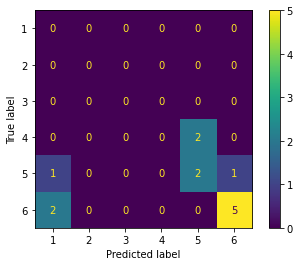

--------------------
Accuracy on testing set is 46.154%
Confusion matrix is


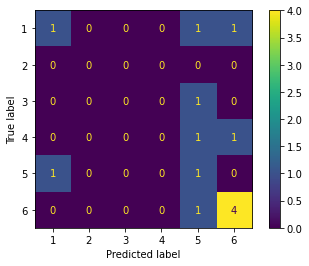

(MultinomialNB(), 0.5384615384615384, 0.46153846153846156)

In [6]:
# Testing
w_extractor:WordExtractor = WordExtractor()
f_extractor:FeatureExtractor = FeatureExtractor(n_word = 2, add_padding = True)

feats:Features = ext.extract_features(w_extractor, f_extractor, "testing_doc.txt", "filename")
evaluate_features(feats)

### Évaluation de la taille des fenêtres
On chercher à évaluer différentes tailles de fenêtre pour la sélection des features. La taille de la fenêtre correspond au nombre de mot avant et après la cible choisis dans chaque phrase.

La méthode retourne le meilleur estimateur ainsi que son erreur sur l'ensemble de test.

In [7]:
def evaluate_feature_extraction(word_extractor:WordExtractor, input:str, input_type:str = 'filename') -> Tuple[MultinomialNB, float]:
    words_before, words_after, targets = word_extractor.extract(input, input_type)

    test_size = [1, 2, 3, 4, 5]

    # Contains the best estimator at each iteration
    estimators:List[MultinomialNB] = []
    valid_accuracies:np.ndarray = np.zeros(len(test_size))
    test_accuracies:np.ndarray = np.zeros(len(test_size))

    for i, size in enumerate(test_size):
        feature_extractor = FeatureExtractor(n_word=size, add_padding=True)
        features = feature_extractor.extract(words_before, words_after, targets)
        print("Testing for window size ", size, "\n")

        # Evaluate the features
        estimator, valid_accuracy, test_accuracy = evaluate_features(features)
        estimators.append(estimator)
        valid_accuracies[i] = valid_accuracy
        test_accuracies[i] = test_accuracy

        print("\n====================\n")

    # Find the best estimator
    best_i = valid_accuracies.argmax()
    best_size = test_size[best_i]
    best_accuracy = valid_accuracies[best_i]
    print("The best accuracy is ", round(best_accuracy*100,3), "% at size ", best_size, sep="")
    print("--------------------")

    # Plot the result
    plt.xlabel("Window size")
    plt.ylabel("Accuracy")

    plt.plot(test_size, valid_accuracies)
    plt.show()

    # Look at the test accuracy
    print("Accuracy on the testing set is ", round(test_accuracies[best_i]*100,3), "%", sep="")
    return estimators[best_i], test_accuracies[best_i]

Testing for window size  1 

Data:  (51, 113)
Train:  (25, 113)
Valid:  (13, 113)
Test:  (13, 113)
--------------------
Accuracy on validation set is 46.154%
Confusion matrix is


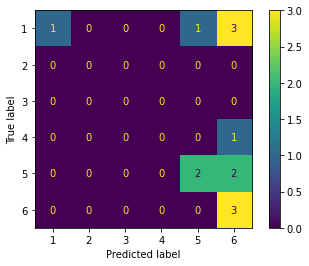

--------------------
Accuracy on testing set is 46.154%
Confusion matrix is


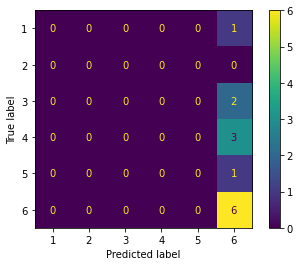



Testing for window size  2 

Data:  (51, 216)
Train:  (25, 216)
Valid:  (13, 216)
Test:  (13, 216)
--------------------
Accuracy on validation set is 53.846%
Confusion matrix is


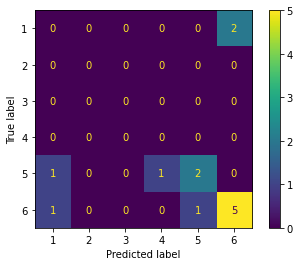

--------------------
Accuracy on testing set is 46.154%
Confusion matrix is


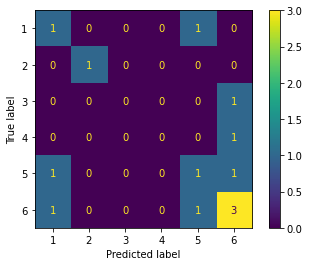



Testing for window size  3 

Data:  (51, 327)
Train:  (25, 327)
Valid:  (13, 327)
Test:  (13, 327)
--------------------
Accuracy on validation set is 53.846%
Confusion matrix is


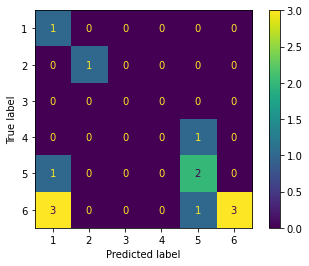

--------------------
Accuracy on testing set is 46.154%
Confusion matrix is


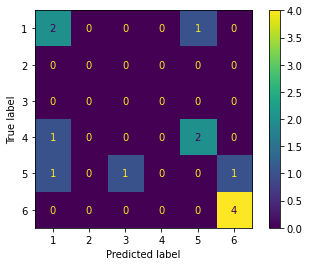



Testing for window size  4 

Data:  (51, 437)
Train:  (25, 437)
Valid:  (13, 437)
Test:  (13, 437)
--------------------
Accuracy on validation set is 23.077%
Confusion matrix is


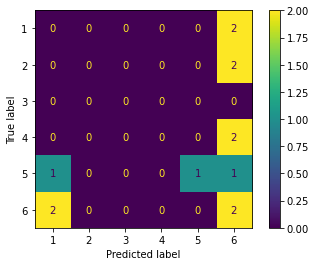

--------------------
Accuracy on testing set is 53.846%
Confusion matrix is


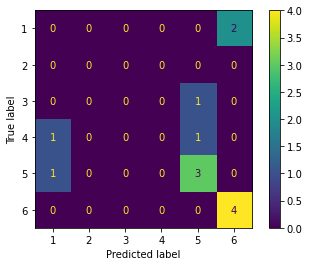



Testing for window size  5 

Data:  (51, 538)
Train:  (25, 538)
Valid:  (13, 538)
Test:  (13, 538)
--------------------
Accuracy on validation set is 38.462%
Confusion matrix is


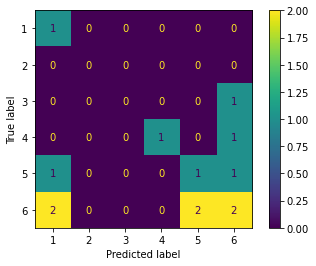

--------------------
Accuracy on testing set is 61.538%
Confusion matrix is


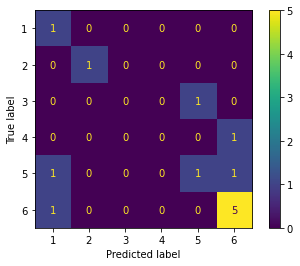



The best accuracy is 53.846% at size 2
--------------------


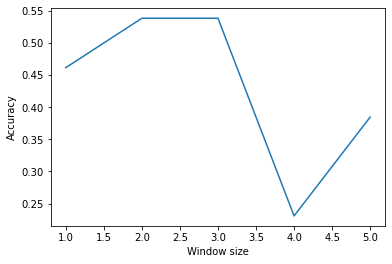

Accuracy on the testing set is 46.154%


(MultinomialNB(), 0.46153846153846156)

In [8]:
# Testing
word_extractor:WordExtractor = WordExtractor()
evaluate_feature_extraction(word_extractor, 'testing_doc.txt', 'filename')

## Extraction des features
On teste différentes techniques d'extractions de features.

1. Cas de base : on garde tous les mots
2. Stopwords : on enlève les stopwords du texte
3. Stemming : on fait du stemming sur les mots gardés

In [9]:
def evaluate_word_extractor(word_extractor:WordExtractor):
    evaluate_feature_extraction(word_extractor, input='interest.txt', input_type='filename')

Testing for window size  1 

Data:  (2368, 1454)
Train:  (1172, 1454)
Valid:  (604, 1454)
Test:  (592, 1454)
--------------------
Accuracy on validation set is 70.364%
Confusion matrix is


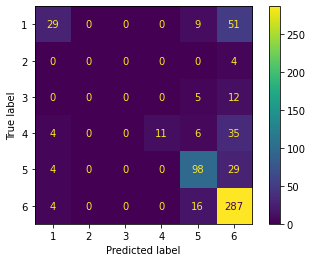

--------------------
Accuracy on testing set is 72.635%
Confusion matrix is


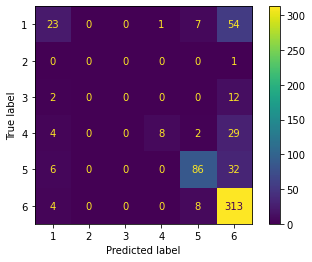



Testing for window size  2 

Data:  (2368, 2442)
Train:  (1172, 2442)
Valid:  (604, 2442)
Test:  (592, 2442)
--------------------
Accuracy on validation set is 74.669%
Confusion matrix is


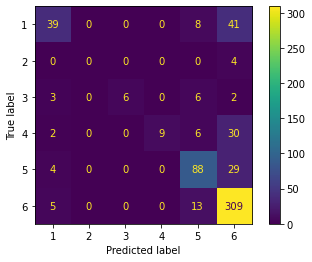

--------------------
Accuracy on testing set is 75.0%
Confusion matrix is


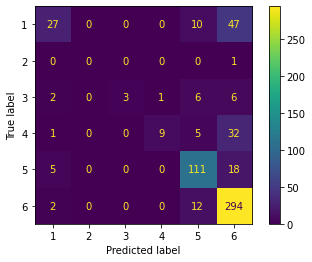



Testing for window size  3 

Data:  (2368, 3184)
Train:  (1172, 3184)
Valid:  (604, 3184)
Test:  (592, 3184)
--------------------
Accuracy on validation set is 71.689%
Confusion matrix is


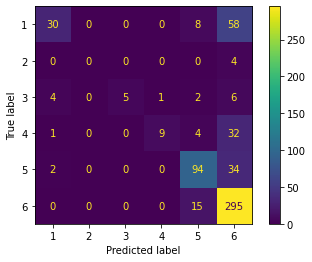

--------------------
Accuracy on testing set is 76.182%
Confusion matrix is


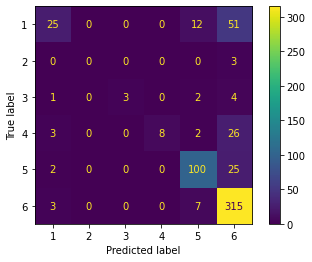



Testing for window size  4 

Data:  (2368, 3842)
Train:  (1172, 3842)
Valid:  (604, 3842)
Test:  (592, 3842)
--------------------
Accuracy on validation set is 73.51%
Confusion matrix is


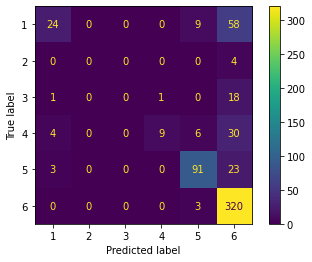

--------------------
Accuracy on testing set is 71.622%
Confusion matrix is


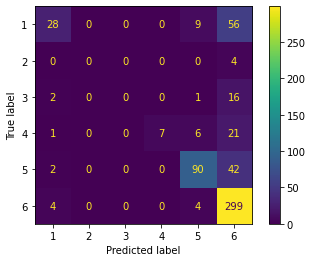



Testing for window size  5 

Data:  (2368, 4397)
Train:  (1172, 4397)
Valid:  (604, 4397)
Test:  (592, 4397)
--------------------
Accuracy on validation set is 69.702%
Confusion matrix is


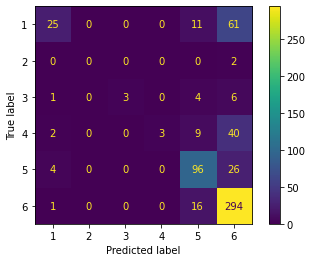

--------------------
Accuracy on testing set is 72.128%
Confusion matrix is


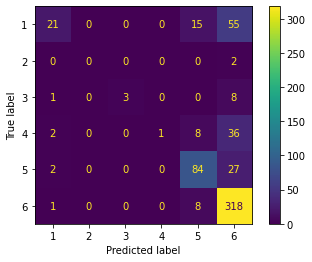



The best accuracy is 74.669% at size 2
--------------------


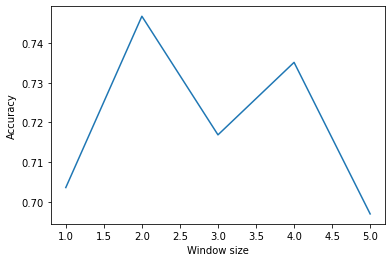

Accuracy on the testing set is 75.0%


In [10]:
# Base case
word_extractor = WordExtractor()
evaluate_word_extractor(word_extractor)

Testing for window size  1 

Data:  (2368, 1692)
Train:  (1172, 1692)
Valid:  (604, 1692)
Test:  (592, 1692)
--------------------
Accuracy on validation set is 71.192%
Confusion matrix is


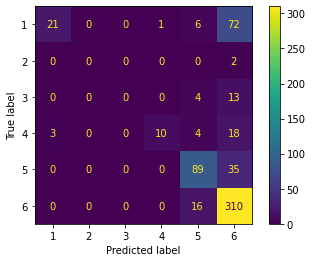

--------------------
Accuracy on testing set is 73.986%
Confusion matrix is


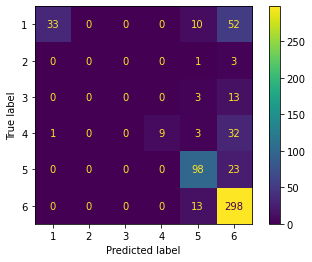



Testing for window size  2 

Data:  (2368, 3030)
Train:  (1172, 3030)
Valid:  (604, 3030)
Test:  (592, 3030)
--------------------
Accuracy on validation set is 70.861%
Confusion matrix is


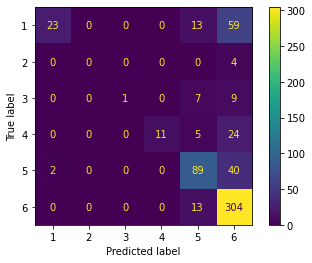

--------------------
Accuracy on testing set is 70.608%
Confusion matrix is


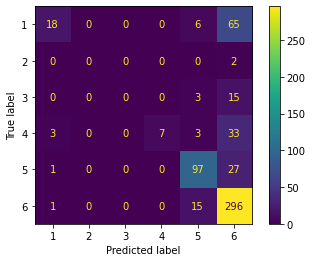



Testing for window size  3 

Data:  (2368, 3988)
Train:  (1172, 3988)
Valid:  (604, 3988)
Test:  (592, 3988)
--------------------
Accuracy on validation set is 69.04%
Confusion matrix is


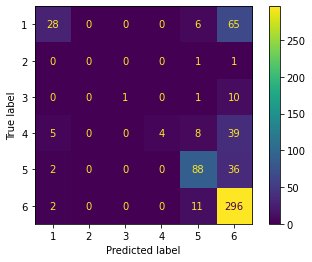

--------------------
Accuracy on testing set is 72.466%
Confusion matrix is


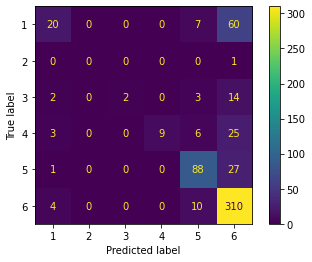



Testing for window size  4 

Data:  (2368, 4785)
Train:  (1172, 4785)
Valid:  (604, 4785)
Test:  (592, 4785)
--------------------
Accuracy on validation set is 74.338%
Confusion matrix is


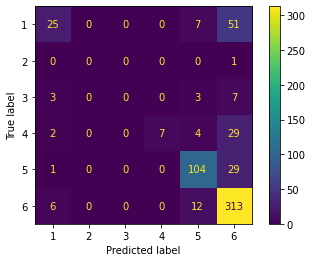

--------------------
Accuracy on testing set is 73.818%
Confusion matrix is


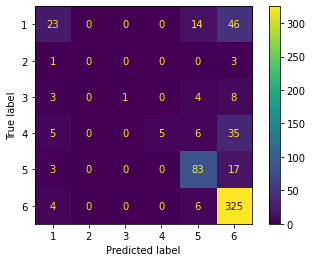



Testing for window size  5 

Data:  (2368, 5396)
Train:  (1172, 5396)
Valid:  (604, 5396)
Test:  (592, 5396)
--------------------
Accuracy on validation set is 70.53%
Confusion matrix is


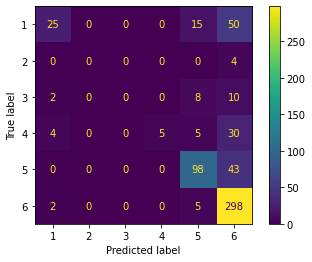

--------------------
Accuracy on testing set is 71.622%
Confusion matrix is


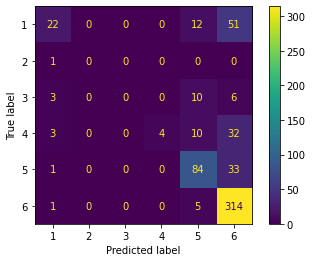



The best accuracy is 74.338% at size 4
--------------------


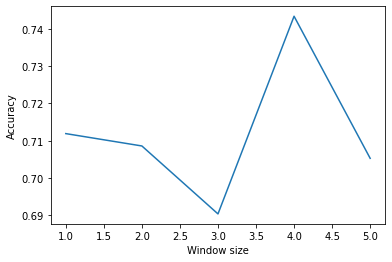

Accuracy on the testing set is 73.818%


In [11]:
# With stopwords
stopwords = ext.read_stopwords_to_regex('stopwords.txt')

word_extractor = WordExtractor(stopwords=stopwords)
evaluate_word_extractor(word_extractor)

Testing for window size  1 

Data:  (2368, 1398)
Train:  (1172, 1398)
Valid:  (604, 1398)
Test:  (592, 1398)
--------------------
Accuracy on validation set is 74.503%
Confusion matrix is


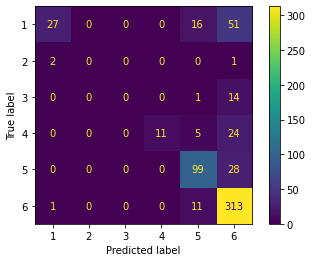

--------------------
Accuracy on testing set is 70.439%
Confusion matrix is


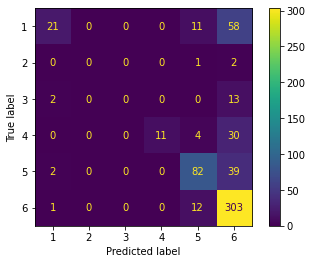



Testing for window size  2 

Data:  (2368, 2452)
Train:  (1172, 2452)
Valid:  (604, 2452)
Test:  (592, 2452)
--------------------
Accuracy on validation set is 73.179%
Confusion matrix is


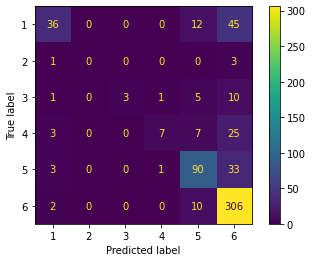

--------------------
Accuracy on testing set is 73.986%
Confusion matrix is


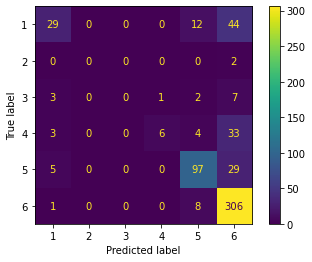



Testing for window size  3 

Data:  (2368, 3148)
Train:  (1172, 3148)
Valid:  (604, 3148)
Test:  (592, 3148)
--------------------
Accuracy on validation set is 75.993%
Confusion matrix is


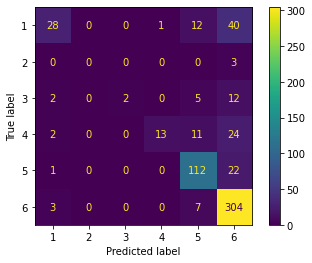

--------------------
Accuracy on testing set is 75.338%
Confusion matrix is


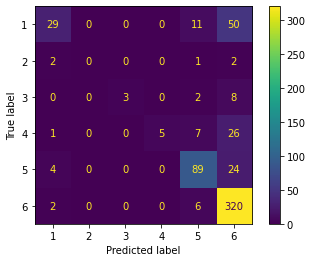



Testing for window size  4 

Data:  (2368, 3761)
Train:  (1172, 3761)
Valid:  (604, 3761)
Test:  (592, 3761)
--------------------
Accuracy on validation set is 71.358%
Confusion matrix is


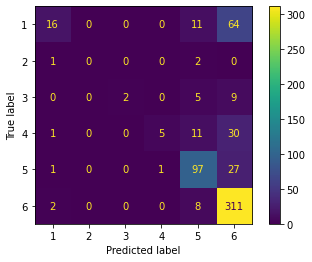

--------------------
Accuracy on testing set is 73.142%
Confusion matrix is


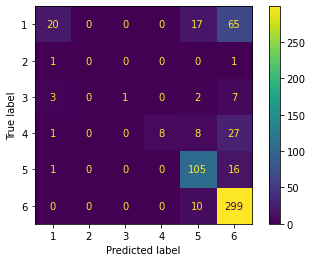



Testing for window size  5 

Data:  (2368, 4223)
Train:  (1172, 4223)
Valid:  (604, 4223)
Test:  (592, 4223)
--------------------
Accuracy on validation set is 70.199%
Confusion matrix is


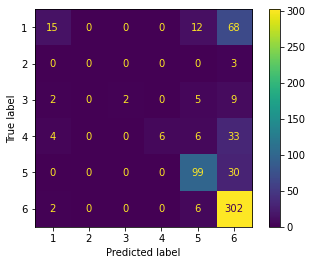

--------------------
Accuracy on testing set is 71.115%
Confusion matrix is


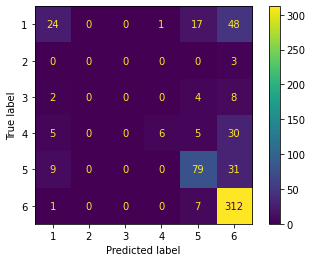



The best accuracy is 75.993% at size 3
--------------------


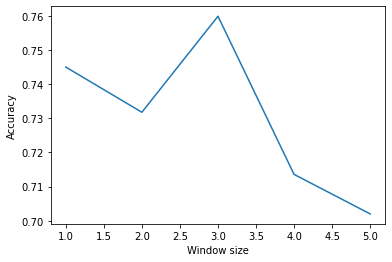

Accuracy on the testing set is 75.338%


In [12]:
# With stemming
stopwords = ext.read_stopwords_to_regex('stopwords.txt')

word_extractor = WordExtractor(stopwords=stopwords, stem=True)
evaluate_word_extractor(word_extractor)